# 1.4 SageMaker Training with Experiments, HPO and Processing

## 학습 작업의 실행 노트북 개요

- SageMaker Training에 SageMaker 실험을 추가하여 여러 실험의 결과를 비교할 수 있습니다.
    - [작업 실행 시 필요 라이브러리 import](#작업-실행-시-필요-라이브러리-import)
    - [SageMaker 세션과 Role, 사용 버킷 정의](#SageMaker-세션과-Role,-사용-버킷-정의)
    - [하이퍼파라미터 정의](#하이퍼파라미터-정의)
    - [학습 실행 작업 정의](#학습-실행-작업-정의)
        - 학습 코드 명
        - 학습 코드 폴더 명
        - 학습 코드가 사용한 Framework 종류, 버전 등
        - 학습 인스턴스 타입과 개수
        - SageMaker 세션
        - 학습 작업 하이퍼파라미터 정의
        - 학습 작업 산출물 관련 S3 버킷 설정 등
    - [학습 데이터셋 지정](#학습-데이터셋-지정)
        - 학습에 사용하는 데이터셋의 S3 URI 지정
    - [SageMaker 실험 설정](#SageMaker-실험-설정)
    - [학습 실행](#학습-실행)
    - [데이터 세트 설명](#데이터-세트-설명)
    - [실험 결과 보기](#실험-결과-보기)
    - [Evaluation 하기](#Evaluation-하기)

### 작업 실행 시 필요 라이브러리 import

In [6]:
import boto3
import sagemaker

### SageMaker 세션과 Role, 사용 버킷 정의

In [7]:
sagemaker_session = sagemaker.session.Session()
region = sagemaker_session._region_name
role = sagemaker.get_execution_role()

In [8]:
bucket = sagemaker_session.default_bucket()
code_location = f's3://{bucket}/xgboost/code'
output_path = f's3://{bucket}/xgboost/output'

### 하이퍼파라미터 정의

In [9]:
hyperparameters = {
       "scale_pos_weight" : 29,    
        "objective": "binary:logistic",
        "num_round": 100,
}

### 학습 실행 작업 정의

In [10]:
instance_count = 1
instance_type = "ml.m5.large"
# instance_type = 'local'
max_run = 1*60*60

use_spot_instances = False
if use_spot_instances:
    max_wait = 1*60*60
else:
    max_wait = None

In [11]:
# image_uri = sagemaker.image_uris.retrieve(
#     "xgboost",
#     version="1.5-1",
#     region=region,
#     image_scope='training',
#     # instance_type=instance_type
# )
# image_uri

In [12]:
if instance_type in ['local', 'local_gpu']:
    from sagemaker.local import LocalSession
    sagemaker_session = LocalSession()
    sagemaker_session.config = {'local': {'local_code': True}}
else:
    sagemaker_session = sagemaker.session.Session()

In [13]:
from sagemaker.xgboost.estimator import XGBoost

# estimator = sagemaker.estimator.Estimator(
estimator = XGBoost(
    entry_point="xgboost_starter_script.py",
    source_dir="src",
    # image_uri=image_uri,
    output_path=output_path,
    code_location=code_location,
    hyperparameters=hyperparameters,
    role=role,
    sagemaker_session=sagemaker_session,
    instance_count=instance_count,
    instance_type=instance_type,
    framework_version="1.3-1",
    max_run=max_run,
    use_spot_instances=use_spot_instances,  # spot instance 활용
    max_wait=max_wait,
)

### 학습 데이터셋 지정

In [14]:
data_path=f's3://{bucket}/xgboost/dataset'
!aws s3 sync ../data/dataset/ $data_path

In [15]:
if instance_type in ['local', 'local_gpu']:
    from pathlib import Path
    file_path = f'file://{Path.cwd()}'
    inputs = file_path.split('lab_1_training')[0] + 'data/dataset/'
    
else:
    inputs = data_path
inputs

's3://sagemaker-us-east-1-654405684375/xgboost/dataset'

### SageMaker 실험 설정

In [16]:
#!pip install sagemaker-experiments


Usage:   
  pip uninstall [options] <package> ...
  pip uninstall [options] -r <requirements file> ...

no such option: -f


In [17]:
experiment_name='xgb-1'

In [18]:
from smexperiments.experiment import Experiment
from smexperiments.trial import Trial
from time import strftime

In [19]:
def create_experiment(experiment_name):
    try:
        sm_experiment = Experiment.load(experiment_name)
    except:
        sm_experiment = Experiment.create(experiment_name=experiment_name)

In [20]:
def create_trial(experiment_name):
    create_date = strftime("%m%d-%H%M%s")       
    sm_trial = Trial.create(trial_name=f'{experiment_name}-{create_date}',
                            experiment_name=experiment_name)

    job_name = f'{sm_trial.trial_name}'
    return job_name

### HPO 실행 + 학습 실행

SageMaker의 [Automatic Model Tuning](https://docs.aws.amazon.com/sagemaker/latest/dg/automatic-model-tuning.html)을 활용할 수 있습니다. 이 방식은 높은 평가 비용의 최적화 문제를 위해 특별히 설계된 베이지안 최적화 방법을 사용합니다. [HyperparameterTuner](https://sagemaker.readthedocs.io/en/stable/tuner.html)의 `fit()` 방법은 `Estimator`와 같이 기본적으로 제공되지 않습니다. (HPO 작업은 일반적으로는 오래 걸리기 때문입니다.) SageMaker console에 있는 "Hyperparameter Tuning Jobs"은 진행되는 작업의 상세 상태와 metrics를 확인하기에 좋은 UI를 제공합니다. 

In [21]:
max_jobs=4    # TODO: Ideally 12 or more
max_parallel_jobs=2   # TODO: Maybe only 1 for Event Engine, 2-3 if possible

In [22]:
create_experiment(experiment_name)
job_name = create_trial(experiment_name)

job_name =  job_name[15:] ## job_name must have length less than or equal to 32 for HPO

tuner = sagemaker.tuner.HyperparameterTuner(
    estimator,
    objective_metric_name="validation:auc",
    hyperparameter_ranges={
        "max_depth": sagemaker.tuner.IntegerParameter(2, 5),
        "eta": sagemaker.tuner.ContinuousParameter(0.1, 0.5)
    },
    objective_type="Maximize",
    max_jobs=max_jobs,    # TODO: Ideally 12 or more
    max_parallel_jobs=max_parallel_jobs,    # TODO: Maybe only 1 for Event Engine, 2-3 if possible
)

tuner.fit(
    job_name = job_name,
    inputs={'inputdata': inputs},
    experiment_config={
          'TrialName': job_name,
          'TrialComponentDisplayName': job_name,
    },
    wait=False
)


INFO:sagemaker:Creating hyperparameter tuning job with name: 1690856778


Using provided s3_resource


In [23]:
tuner.wait()

..................................................!


###  실험 결과 보기
위의 실험한 결과를 확인 합니다.
- 각각의 훈련잡의 시도에 대한 훈련 사용 데이터, 모델 입력 하이퍼 파라미터, 모델 평가 지표, 모델 아티펙트 결과 위치 등의 확인이 가능합니다.
- **아래의 모든 내용은 SageMaker Studio 를 통해서 직관적으로 확인이 가능합니다.**

In [24]:
from sagemaker.analytics import ExperimentAnalytics, HyperparameterTuningJobAnalytics
import pandas as pd
pd.options.display.max_columns = 50
pd.options.display.max_rows = 10
pd.options.display.max_colwidth = 100

In [25]:
trial_component_training_analytics = HyperparameterTuningJobAnalytics(
    sagemaker_session= sagemaker_session,
    hyperparameter_tuning_job_name=job_name
)

trial_component_training_analytics.dataframe()[['TrainingJobName', 'TrainingJobStatus', 
                                                'eta', 'max_depth', 'FinalObjectiveValue']]

,TrainingJobName,TrainingJobStatus,eta,max_depth,FinalObjectiveValue
0,1690856778-004-61cea020,Completed,0.364902,4.0,0.803695
1,1690856778-003-5662364c,Completed,0.135890,4.0,0.805997
2,1690856778-002-4161c68b,Completed,0.402608,2.0,0.819125
3,1690856778-001-949c388b,Completed,0.315602,3.0,0.818043


###  Evaluation 하기
SageMaker Processing을 이용하여 Evalution을 수행하는 코드를 동작할 수 있습니다. MLOps에서 Processing을 적용하면 전처리, Evaluation 등을 serverless로 동작할 수 있습니다.

In [26]:
from sagemaker.processing import FrameworkProcessor
from sagemaker.processing import ProcessingInput, ProcessingOutput

In [27]:
instance_count = 1
instance_type = "ml.m5.large"
# instance_type = 'local'

In [28]:
script_eval = FrameworkProcessor(
    XGBoost,
    framework_version="1.3-1",
    role=role,
    instance_type=instance_type,
    instance_count=instance_count
)

INFO:sagemaker.image_uris:Ignoring unnecessary Python version: py3.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: ml.m5.large.


In [29]:
client = boto3.client('sagemaker')
response = client.describe_training_job(
    TrainingJobName=tuner.best_training_job()
)

In [30]:
artifacts_dir = response['ModelArtifacts']['S3ModelArtifacts']
artifacts_dir

's3://sagemaker-us-east-1-654405684375/xgboost/output/1690856778-002-4161c68b/output/model.tar.gz'

In [31]:
s3_test_path = data_path + '/test.csv'
detect_outputpath = f's3://{bucket}/xgboost/processing'

In [32]:
from pathlib import Path
source_dir = f'{Path.cwd()}/src'

if instance_type == 'local':
    from sagemaker.local import LocalSession
    from pathlib import Path

    sagemaker_session = LocalSession()
    sagemaker_session.config = {'local': {'local_code': True}}

    s3_test_path=f'../data/dataset/test.csv'
else:
    sagemaker_session = sagemaker.session.Session()
    s3_test_path=data_path + '/test.csv'  

In [33]:
create_experiment(experiment_name)
job_name = create_trial(experiment_name)

script_eval.run(
    code="evaluation.py",
    source_dir=source_dir,
    inputs=[ProcessingInput(source=s3_test_path, input_name="test_data", destination="/opt/ml/processing/test"),
            ProcessingInput(source=artifacts_dir, input_name="model_weight", destination="/opt/ml/processing/model")
    ],
    outputs=[
        ProcessingOutput(source="/opt/ml/processing/output", output_name='evaluation', destination=detect_outputpath + "/" + job_name),
    ],
    job_name=job_name,
    experiment_config={
        'TrialName': job_name,
        'TrialComponentDisplayName': job_name,
    },
    wait=False
)

INFO:sagemaker.processing:Uploaded /root/sagemaker-basic/lab_1_training/src to s3://sagemaker-us-east-1-654405684375/xgb-1-0801-02301690857042/source/sourcedir.tar.gz


Using provided s3_resource


INFO:sagemaker.processing:runproc.sh uploaded to s3://sagemaker-us-east-1-654405684375/xgb-1-0801-02301690857042/source/runproc.sh
INFO:sagemaker:Creating processing-job with name xgb-1-0801-02301690857042


In [34]:
script_eval.latest_job.wait()

............................Requirement already satisfied: xgboost in /miniconda3/lib/python3.7/site-packages (1.3.3)
[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
#############################################
args.model_path: /opt/ml/processing/model/model.tar.gz
args.test_path: /opt/ml/processing/test/test.csv
args.output_evaluation_dir: /opt/ml/processing/output
****** All folder and files under /opt/ml/processing ****** 
('/opt/ml/processing', ['test', 'model', 'input', 'output'], [])
('/opt/ml/processing/test', [], ['test.csv'])
('/opt/ml/processing/model', [], ['model.tar.gz'])
('/opt/ml/processing/input', ['entrypoint', 'code'], [])
('/opt/ml/processing/input/entrypoint', [], ['runproc.sh'])
('/opt/ml/processing/input/code', ['.ipynb_checkpoints'], ['evaluation.py', 'xgboost_starter_script.py', 'sourcedir.tar.gz'])
('/opt/ml/processing/input/code/.ipynb_checkpoints', [], ['xgboost_starter_script-checkpoint.py'])
(

###  실험 결과 확인

In [35]:
# artifacts_dir = xgb_estimator.model_data.replace('model.tar.gz', '')
print(artifacts_dir)
!aws s3 ls --human-readable {artifacts_dir}

s3://sagemaker-us-east-1-654405684375/xgboost/output/1690856778-002-4161c68b/output/model.tar.gz
2023-08-01 02:29:13    1.5 KiB model.tar.gz


In [36]:
model_dir = './model'

!rm -rf $model_dir

import json , os

if not os.path.exists(model_dir):
    os.makedirs(model_dir)

!aws s3 cp {artifacts_dir} {model_dir}/model.tar.gz
!tar -xvzf {model_dir}/model.tar.gz -C {model_dir}

download: s3://sagemaker-us-east-1-654405684375/xgboost/output/1690856778-002-4161c68b/output/model.tar.gz to model/model.tar.gz
xgboost-model


In [37]:
!pip install xgboost graphviz

  Using cached xgboost-1.6.2-py3-none-manylinux2014_x86_64.whl (255.9 MB)
  Using cached graphviz-0.20.1-py3-none-any.whl (47 kB)

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [55]:
import xgboost as xgb
import matplotlib.pyplot as plt

In [56]:
model = xgb.XGBClassifier()
model.load_model("./model/xgboost-model")

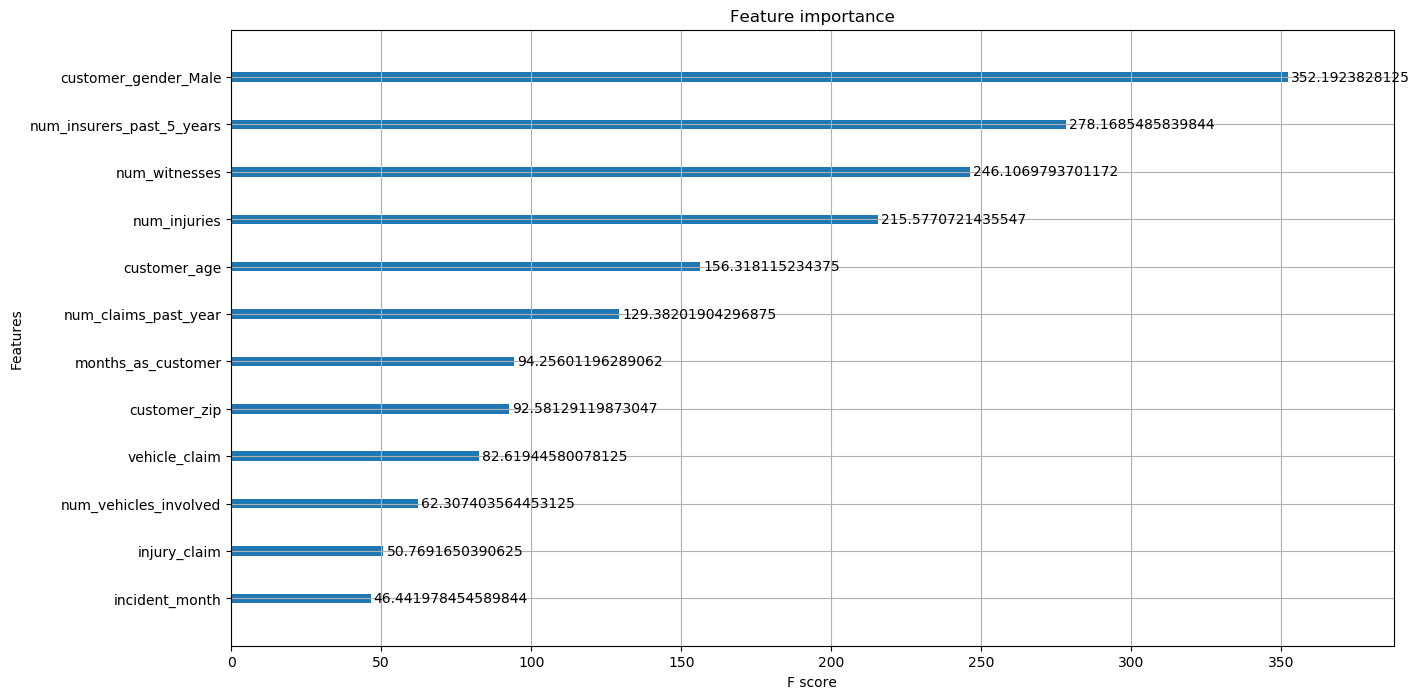

In [61]:
test_prep_df = pd.read_csv('../data/dataset/test.csv')
x_test = test_prep_df.drop('fraud', axis=1)
feature_data = xgb.DMatrix(x_test)
model.get_booster().feature_names = feature_data.feature_names
model.get_booster().feature_types = feature_data.feature_types
fig, ax = plt.subplots(figsize=(15, 8))
xgb.plot_importance(model, ax=ax, importance_type='gain')
plt.show()

In [ ]:
# only available on SageMaker notebook but not SageMaker Studio
# xgb.plot_tree(model, num_trees=0, rankdir='LR')

# fig = plt.gcf()
# fig.set_size_inches(50, 15)
# plt.show()

AttributeError: 'AxesSubplot' object has no attribute 'gcf'